In [1]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,RationalQuadratic
from sklearn.preprocessing import LabelEncoder
from scipy.special import expit
from scipy.linalg import cholesky, cho_solve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import signal
import IPython

In [3]:
# based on the classification model used in lecture
class mnist_nn_model(nn.Module):
    def __init__(self):
        # just need to define it the other way, and then can just return the outputs from any given layer in a similar way to classify
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.pool = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(.25)
        self.flat = nn.Flatten(1)
        self.lin1 = nn.Linear(9216,128)
        self.drop2 = nn.Dropout2d(.25)
        self.lin2 = nn.Linear(128,16)
        self.lin3 = nn.Linear(16,10)
    
    def forward(self,x,y):
        # log likelihood for a batch of data
        return - nn.functional.cross_entropy(self.f(x), y, reduction='none')
    
    def last_layer(self, x):
        # computing in parts so it is easy to pull out different internal pieces
        pooled = self.pool(nn.functional.relu(self.conv2(nn.functional.relu(self.conv1(x)))))
        lin1 = self.lin1(self.flat(self.drop1(nn.functional.relu(pooled))))
        lin2 = self.lin2(self.drop2(nn.functional.relu(lin1)))
        return lin2
    
    def f(self, x):
        return self.lin3(nn.functional.relu(self.last_layer(x)))
    def classify(self,x):
        # class probabilities for a single data point
        q = self.f(torch.as_tensor(x)[None,...])[0]
        return nn.functional.softmax(q, dim=0)

In [4]:
nn_model = mnist_nn_model()
optimizer = optim.Adam(nn_model.parameters())
nn_model.train(mode = False)
nn_model.load_state_dict(torch.load('cnn_classifier.pt'))

<All keys matched successfully>

In [6]:
# load all the datasets
X_orig = pd.read_csv('X_orig_binary.csv')
Y_orig = pd.read_csv('Y_orig_binary.csv')
X_test = pd.read_csv('X_test_binary.csv')
Y_test = pd.read_csv('Y_test_binary.csv')
X_white_noise = pd.read_csv('X_white_noise_binary.csv')
Y_white_noise = pd.read_csv('Y_white_noise_binary.csv')
X_motion_blur = pd.read_csv('X_motion_blur_binary.csv')
Y_motion_blur = pd.read_csv('Y_motion_blur_binary.csv')
X_reduced_contrast = pd.read_csv('X_reduced_contrast_binary.csv')
Y_reduced_contrast = pd.read_csv('Y_reduced_contrast_binary.csv')
X_fgm10 = pd.read_csv('X_fgm_10_binary.csv')
Y_fgm10 = pd.read_csv('Y_fgm_10_binary.csv')
X_fgm25 = pd.read_csv('X_fgm_25_binary.csv')
Y_fgm25 = pd.read_csv('Y_fgm_25_binary.csv')
X_fgm50 = pd.read_csv('X_fgm_50_binary.csv')
Y_fgm50 = pd.read_csv('Y_fgm_50_binary.csv')
X_fgm100 = pd.read_csv('X_fgm_100_binary.csv')
Y_fgm100 = pd.read_csv('Y_fgm_100_binary.csv')
X_pgd10 = pd.read_csv('X_pgd_10_binary.csv')
Y_pgd10 = pd.read_csv('Y_pgd_10_binary.csv')
X_pgd25 = pd.read_csv('X_pgd_25_binary.csv')
Y_pgd25 = pd.read_csv('Y_pgd_25_binary.csv')
X_pgd50 = pd.read_csv('X_pgd_50_binary.csv')
Y_pgd50 = pd.read_csv('Y_pgd_50_binary.csv')
X_pgd100 = pd.read_csv('X_pgd_100_binary.csv')
Y_pgd100 = pd.read_csv('Y_pgd_100_binary.csv')

del X_orig['Unnamed: 0']
del Y_orig['Unnamed: 0']
del X_test['Unnamed: 0']
del Y_test['Unnamed: 0']
del X_white_noise['Unnamed: 0']
del Y_white_noise['Unnamed: 0']
del X_motion_blur['Unnamed: 0']
del Y_motion_blur['Unnamed: 0']
del X_reduced_contrast['Unnamed: 0']
del Y_reduced_contrast['Unnamed: 0']
del X_fgm10['Unnamed: 0']
del Y_fgm10['Unnamed: 0']
del X_fgm25['Unnamed: 0']
del Y_fgm25['Unnamed: 0']
del X_fgm50['Unnamed: 0']
del Y_fgm50['Unnamed: 0']
del X_fgm100['Unnamed: 0']
del Y_fgm100['Unnamed: 0']
del X_pgd10['Unnamed: 0']
del Y_pgd10['Unnamed: 0']
del X_pgd25['Unnamed: 0']
del Y_pgd25['Unnamed: 0']
del X_pgd50['Unnamed: 0']
del Y_pgd50['Unnamed: 0']
del X_pgd100['Unnamed: 0']
del Y_pgd100['Unnamed: 0']


In [7]:
# convert the dataframes to np arrays for easier processing
X_orig = X_orig.to_numpy()
Y_orig = Y_orig.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
X_white_noise = X_white_noise.to_numpy()
Y_white_noise = Y_white_noise.to_numpy()
X_motion_blur = X_motion_blur.to_numpy()
Y_motion_blur = Y_motion_blur.to_numpy()
X_reduced_contrast = X_reduced_contrast.to_numpy()
Y_reduced_contrast = Y_reduced_contrast.to_numpy()
X_fgm10 = X_fgm10.to_numpy()
Y_fgm10 = Y_fgm10.to_numpy()
X_fgm25 = X_fgm25.to_numpy()
Y_fgm25 = Y_fgm25.to_numpy()
X_fgm50 = X_fgm50.to_numpy()
Y_fgm50 = Y_fgm50.to_numpy()
X_fgm100 = X_fgm100.to_numpy()
Y_fgm100 = Y_fgm100.to_numpy()
X_pgd10 = X_pgd10.to_numpy()
Y_pgd10 = Y_pgd10.to_numpy()
X_pgd25 = X_pgd25.to_numpy()
Y_pgd25 = Y_pgd25.to_numpy()
X_pgd50 = X_pgd50.to_numpy()
Y_pgd50 = Y_pgd50.to_numpy()
X_pgd100 = X_pgd100.to_numpy()
Y_pgd100 = Y_pgd100.to_numpy()

In [7]:
# load the full images for the neural network classifier as well
# load the standard mnist dataset
mnist_train = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = True,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)
mnist_batched = torch.utils.data.DataLoader(mnist_train, batch_size=100)
X_orig_img = torch.stack([img for img,lbl in mnist_train if lbl==0 or lbl ==1])
Y_orig_img = [lbl for img,lbl in mnist_train if lbl == 0 or lbl == 1]


In [8]:
mnist_test = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = False,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)
X_test_img = torch.stack([img for img,lbl in mnist_train if lbl==0 or lbl ==1])
Y_test_img = [lbl for img,lbl in mnist_train if lbl == 0 or lbl == 1]

In [60]:
import requests, io
import scipy.io

In [61]:
r = requests.get("https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/nmnist/mnist-with-awgn.mat")

with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
wn_train_x = data['train_x'].reshape(60000,1,28,28)
wn_train_y = data['train_y']
decoded = np.argmax(wn_train_y, axis=1)
wn_y_bin = np.array([lbl for lbl in decoded if lbl == 0 or lbl == 1])
wn_x_bin = torch.stack([torch.Tensor(img)/255 for i,img in enumerate(wn_train_x) if decoded[i]==0 or decoded[i]==1])


In [63]:
r = requests.get("https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/nmnist/mnist-with-motion-blur.mat")

with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    mb_train_x = data['train_x'].reshape(60000,1,28,28)
    mb_train_y = data['train_y']
    decoded = np.argmax(mb_train_y, axis=1)
    mb_y_bin = np.array([lbl for lbl in decoded if lbl == 0 or lbl == 1])
    mb_x_bin = torch.stack([torch.Tensor(img)/255 for i,img in enumerate(mb_train_x) if decoded[i]==0 or decoded[i]==1])


In [65]:
r = requests.get("https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/nmnist/mnist-with-reduced-contrast-and-awgn.mat")

with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    rc_train_x = data['train_x'].reshape(60000,1,28,28)
    rc_train_y = data['train_y']
    decoded = np.argmax(rc_train_y, axis=1)
    rc_y_bin = np.array([lbl for lbl in decoded if lbl == 0 or lbl == 1])
    rc_x_bin = torch.stack([torch.Tensor(img)/255 for i,img in enumerate(rc_train_x) if decoded[i]==0 or decoded[i]==1])

In [11]:
X_fgm_10_images = torch.load('X_fgm_10_images.pt')
X_fgm_25_images = torch.load('X_fgm_25_images.pt')
X_fgm_50_images = torch.load('X_fgm_50_images.pt')
X_fgm_100_images = torch.load('X_fgm_100_images.pt')
X_pgd_10_images = torch.load('X_pgd_10_images.pt')
X_pgd_25_images = torch.load('X_pgd_25_images.pt')
X_pgd_50_images = torch.load('X_pgd_50_images.pt')
X_pgd_100_images = torch.load('X_pgd_100_images.pt')

In [2]:
# create a Gaussian Process classifier with a basic RBF kernel added
# to a white noise kernel
kernel =  RBF(1) + WhiteKernel(noise_level=.1)
gpc = GaussianProcessClassifier(kernel = kernel)

Now, we can fit a Gaussian Process on the original MNIST dataset. With that classifier trained, we will be able to compare the measurements of epistemic uncertainty and classifier accuracy across different perturbations of the dataset. 

Fitting a Gaussian Process takes $O(n^3)$ time in the number of datapoints trained on, so I am using only a subset of the datapoints available here to make processing time reasonable.

In [48]:
gpc.fit(X_orig[:3000], Y_orig[:3000].reshape(3000,))

GaussianProcessClassifier(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=0.1))

In [13]:
# we can also save this model for future use
import pickle
pickle.dump(gpc, open('gpc_trained.pkl','wb'))


NameError: name 'gpc' is not defined

In [4]:
import pickle
gpc = pickle.load(open('gpc_trained.pkl','rb'))

Now that we have a trained GP classifier, we will first compare the accuracy of this model with the accuracy of the neural net we trained in notebook 1 on the original MNIST dataset and the noisy datasets. This serves as a sanity check that our classifier works, and a benchmark for the relative performance we can expect.

First, we define some helper functions to return accuracy scores for both the GP classifier and the original NN classifier.

In [16]:
def score_gpc(gpc,x,y):
    pred = gpc.predict(x)
    compare = (pred == y)[0]
    return sum(1 for i in compare if i) / y.size

In [17]:
def score_nn(nn,x,y):
    correct = 0
    for i,img in enumerate(x):
        probs = nn.classify(img)
        pred = np.argmax(probs.detach().numpy())
        if pred == y[i]:
            correct += 1
    return correct / len(y)

In [28]:
print(f"MNIST train :3000 dataset, the GP classifier has an accuracy of {score_gpc(gpc,X_orig[:3000],Y_orig[:3000].reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_orig_img[:3000], Y_orig_img[:3000])}")

MNIST train :3000 dataset, the GP classifier has an accuracy of 0.9996666666666667 and the NN classifier has an accuracy of 0.997


In [29]:
print(f"MNIST train 3000: dataset, the GP classifier has an accuracy of {score_gpc(gpc,X_orig[3000:],Y_orig[3000:].reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_orig_img[3000:], Y_orig_img[3000:])}")

MNIST train :3000 dataset, the GP classifier has an accuracy of 1.0 and the NN classifier has an accuracy of 0.9973098810139679


In [30]:
print(f"MNIST test dataset, the GP classifier has an accuracy of {score_gpc(gpc,X_test,Y_test.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_test_img, Y_test_img)}")

MNIST test dataset, the GP classifier has an accuracy of 1.0 and the NN classifier has an accuracy of 0.9972364784840111


In [62]:
print(f"On the dataset with added white noise, the GP classifier has an accuracy of {score_gpc(gpc,X_white_noise,Y_white_noise.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, wn_x_bin, wn_y_bin)}")

On the dataset with added white noise, the GP classifier has an accuracy of 0.9924200552704303 and the NN classifier has an accuracy of 0.7394393999210422


In [64]:
print(f"On the dataset with motion blur, the GP classifier has an accuracy of {score_gpc(gpc,X_motion_blur,Y_motion_blur.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, mb_x_bin, mb_y_bin)}")

On the dataset with motion blur, the GP classifier has an accuracy of 0.9973154362416108 and the NN classifier has an accuracy of 0.9900513225424398


In [66]:
print(f"On the dataset with reduced contrast and added white noise, the GP classifier has an accuracy of {score_gpc(gpc,X_reduced_contrast,Y_reduced_contrast.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, rc_x_bin, rc_y_bin)}")

On the dataset with reduced contrast and added white noise, the GP classifier has an accuracy of 0.6577181208053692 and the NN classifier has an accuracy of 0.36628503750493485


In [20]:
print(f"On the fgm 10 data, the GP classifier has an accuracy of {score_gpc(gpc,X_fgm10,Y_fgm10.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_fgm_10_images, Y_fgm10)}")

On the fgm 10 data, the GP classifier has an accuracy of 0.9971575207264114 and the NN classifier has an accuracy of 0.88251085669167


In [21]:
print(f"On the fgm 25 data, the GP classifier has an accuracy of {score_gpc(gpc,X_fgm25,Y_fgm25.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_fgm_25_images, Y_fgm25)}")

On the fgm 25 data, the GP classifier has an accuracy of 0.8656 and the NN classifier has an accuracy of 0.1986


In [22]:
print(f"On the fgm 50 data, the GP classifier has an accuracy of {score_gpc(gpc,X_fgm50,Y_fgm50.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_fgm_50_images, Y_fgm50)}")

On the fgm 50 data, the GP classifier has an accuracy of 0.7002 and the NN classifier has an accuracy of 0.053


In [23]:
print(f"On the fgm 100 data, the GP classifier has an accuracy of {score_gpc(gpc,X_fgm100,Y_fgm100.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_fgm_100_images, Y_fgm100)}")

On the fgm 100 data, the GP classifier has an accuracy of 0.5576 and the NN classifier has an accuracy of 0.0316


In [24]:
print(f"On the pgd 10 data, the GP classifier has an accuracy of {score_gpc(gpc,X_pgd10,Y_pgd10.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_pgd_10_images, Y_pgd10)}")

On the pgd 10 data, the GP classifier has an accuracy of 0.9933333333333333 and the NN classifier has an accuracy of 0.09933333333333333


In [25]:
print(f"On the pgd 25 data, the GP classifier has an accuracy of {score_gpc(gpc,X_pgd25,Y_pgd25.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_pgd_25_images, Y_pgd25)}")

On the pgd 25 data, the GP classifier has an accuracy of 0.7233333333333334 and the NN classifier has an accuracy of 0.004


In [26]:
print(f"On the pgd 50 data, the GP classifier has an accuracy of {score_gpc(gpc,X_pgd50,Y_pgd50.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_pgd_50_images, Y_pgd50)}")

On the pgd 50 data, the GP classifier has an accuracy of 0.49666666666666665 and the NN classifier has an accuracy of 0.0006666666666666666


In [27]:
print(f"On the pgd 100 data, the GP classifier has an accuracy of {score_gpc(gpc,X_pgd100,Y_pgd100.reshape(1,-1))} and the NN classifier has an accuracy of {score_nn(nn_model, X_pgd_100_images, Y_pgd100)}")

On the pgd 100 data, the GP classifier has an accuracy of 0.4646666666666667 and the NN classifier has an accuracy of 0.0


From these initial results, we can see that the GP classifier performance is satisfactory. However, it is not fair to say that the NN performance is unsatisfactory because the NN is trained to classify all 10 digits, while the GP only chooses between 2. Since the focus of this project is on the evaluation of epistemic uncertainty in a GP classifier, this discrepancy is unimportant, and the tests above serve only as a sanity check.

Next, we can begin to explore the uncertainty in this classifier on different datasets. First, I will just look at the average uncertainty over all the datasets to understand how well the classifier 'thinks' it knows the data

In [8]:
u_orig_first = []
u_orig_second = []
u_test = []
u_white_noise = []
u_motion_blur = []
u_reduced_contrast = []
u_fgm10 = []
u_fgm25 = []
u_fgm50 = []
u_fgm100 = []
u_pgd10 = []
u_pgd25 = []
u_pgd50 = []
u_pgd100 = []
gpc.predict_proba(X_orig[:3000], uncertainty = u_orig_first)
gpc.predict_proba(X_orig[3000:], uncertainty = u_orig_second)
gpc.predict_proba(X_test, uncertainty = u_test)
gpc.predict_proba(X_white_noise, uncertainty = u_white_noise)
gpc.predict_proba(X_motion_blur, uncertainty = u_motion_blur)
gpc.predict_proba(X_reduced_contrast, uncertainty = u_reduced_contrast)
gpc.predict_proba(X_fgm10, uncertainty = u_fgm10)
gpc.predict_proba(X_fgm25, uncertainty = u_fgm25)
gpc.predict_proba(X_fgm50, uncertainty = u_fgm50)
gpc.predict_proba(X_fgm100, uncertainty = u_fgm100)
gpc.predict_proba(X_pgd10, uncertainty = u_pgd10)
gpc.predict_proba(X_pgd25, uncertainty = u_pgd25)
gpc.predict_proba(X_pgd50, uncertainty = u_pgd50)
gpc.predict_proba(X_pgd100, uncertainty = u_pgd100)
u_orig_first = np.array(u_orig_first)
u_orig_second = np.array(u_orig_second)
u_test = np.array(u_test)
u_white_noise = np.array(u_white_noise)
u_motion_blur = np.array(u_motion_blur)
u_reduced_contrast = np.array(u_reduced_contrast)
u_fgm10 = np.array(u_fgm10)
u_fgm25 = np.array(u_fgm25)
u_fgm50 = np.array(u_fgm50)
u_fgm100 = np.array(u_fgm100)
u_pgd10 = np.array(u_pgd10)
u_pgd25 = np.array(u_pgd25)
u_pgd50 = np.array(u_pgd50)
u_pgd100 = np.array(u_pgd100)


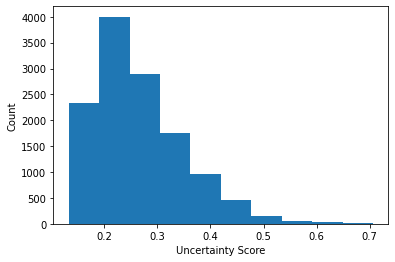

In [39]:
u_total = np.concatenate([u_orig_first, u_orig_second], axis=1)
u_total.shape
plt.hist(u_total[0])
plt.ylabel("Count")
plt.xlabel("Uncertainty Score")
plt.savefig("uncertainty_trainset.png",bbox_inches='tight')

In [9]:
print(f"Avg uncertainty original dataset: {u_orig_first.mean()}")
print(f"Avg uncertainty original dataset: {u_orig_second.mean()}")
print(f"Avg uncertainty original dataset: {u_test.mean()}")
print(f"Avg uncertainty white noise dataset: {u_white_noise.mean()}")
print(f"Avg uncertainty motion blur dataset: {u_motion_blur.mean()}")
print(f"Avg uncertainty reduced contrast dataset: {u_reduced_contrast.mean()}")
print(f"Avg uncertainty FGM, eps = .1 dataset: {u_fgm10.mean()}")
print(f"Avg uncertainty FGM, eps = .25 dataset: {u_fgm25.mean()}")
print(f"Avg uncertainty FGM, eps = .5 dataset: {u_fgm50.mean()}")
print(f"Avg uncertainty FGM, eps = 1 dataset: {u_fgm100.mean()}")
print(f"Avg uncertainty PGD, eps = .1 dataset: {u_pgd10.mean()}")
print(f"Avg uncertainty PGD, eps = .25 dataset: {u_pgd25.mean()}")
print(f"Avg uncertainty PGD, eps = .5 dataset: {u_pgd50.mean()}")
print(f"Avg uncertainty PGD, eps = 1 dataset: {u_pgd100.mean()}")

Avg uncertainty original dataset: 0.26461952675577394
Avg uncertainty original dataset: 0.265736011602283
Avg uncertainty original dataset: 0.26122360566986935
Avg uncertainty white noise dataset: 0.33641428580158533
Avg uncertainty motion blur dataset: 0.2371890128783516
Avg uncertainty reduced contrast dataset: 0.3920097316459086
Avg uncertainty FGM, eps = .1 dataset: 0.33038952362142887
Avg uncertainty FGM, eps = .25 dataset: 0.4663663257186983
Avg uncertainty FGM, eps = .5 dataset: 0.5786015014606509
Avg uncertainty FGM, eps = 1 dataset: 0.8496510669234898
Avg uncertainty PGD, eps = .1 dataset: 0.6013098050427522
Avg uncertainty PGD, eps = .25 dataset: 0.9859089753844558
Avg uncertainty PGD, eps = .5 dataset: 0.9997566555601982
Avg uncertainty PGD, eps = 1 dataset: 1.0000070607326048


With just this simple analysis, we can notice several things:
* the epistemic uncertainty for the original dataset is very small even though the classifier was only trained on a subset of these images
* As the value of epsilon (maximum perturbation from original) increases for the adversarial examples, the uncertainty increases as well.
* If we compare the uncertainty results with the accuracy results from above, we can see that higher uncertainty and lower accuracy are not always correlated.

We will keep these in mind in notebook 3 when we explore evaluation metrics for classification models with a measure of epistemic uncertainty.

In [35]:
# next, look at log likelihood of each different dataset
# this repeats much of the Laplace estimation used in fitting the model as well
def avg_log_likelihood_dataset(gpc, x, y, max_iter=100):
    # marginal log likelihood, won't actually use this
    label_encoder = LabelEncoder()
    y_adj = label_encoder.fit_transform(y)
    f = np.zeros_like(y_adj, dtype=np.float64)
    K = gpc.kernel(x)
    log_marginal_likelihood = -np.inf
    for _ in range(max_iter):
        # Line 4
        pi = expit(f)
        W = pi * (1 - pi)
        # Line 5
        W_sr = np.sqrt(W)
        W_sr_K = W_sr[:, np.newaxis] * K
        B = np.eye(W.shape[0]) + W_sr_K * W_sr
        L = cholesky(B, lower=True)
        # Line 6
        b = W * f + (y_adj - pi)
        # Line 7
        a = b - W_sr * cho_solve((L, True), W_sr_K.dot(b))
        # Line 8
        f = K.dot(a)

        # Line 10: Compute log marginal likelihood in loop and use as
        #          convergence criterion
        lml = (
            -0.5 * a.T.dot(f)
            - np.log1p(np.exp(-(y_adj * 2 - 1) * f)).sum()
            - np.log(np.diag(L)).sum()
        )
        # Check if we have converged (log marginal likelihood does
        # not decrease)
        if lml - log_marginal_likelihood < 1e-10:
            break
        log_marginal_likelihood = lml
    return log_marginal_likelihood / y.size



In [17]:
def avg_log_likelihood_dataset(gpc, x, y):
    probs = gpc.predict_proba(x)
    total_loglik = 0
    for i,true in enumerate(y):
        total_loglik += np.log(probs[i][true])[0]
    return total_loglik / y.size


In [22]:
avg_log_likelihood_dataset(gpc, X_orig[3000:], Y_orig[3000:].reshape(-1,1))

-0.008248755210182007

In [19]:
avg_log_likelihood_dataset(gpc, X_test, Y_test.reshape(-1,1))

-0.00834267163133084

In [20]:
print (f"Likelihood of white noise dataset: {avg_log_likelihood_dataset(gpc, X_white_noise, Y_white_noise.reshape(-1,1))}")
print (f"Likelihood of motion blur dataset: {avg_log_likelihood_dataset(gpc, X_motion_blur, Y_motion_blur.reshape(-1,1))}")
print (f"Likelihood of reduced contrast dataset: {avg_log_likelihood_dataset(gpc, X_reduced_contrast, Y_reduced_contrast.reshape(-1,1))}")
print (f"Likelihood of fgm10 dataset: {avg_log_likelihood_dataset(gpc, X_fgm10, Y_fgm10.reshape(-1,1))}")
print (f"Likelihood of fgm25 dataset: {avg_log_likelihood_dataset(gpc, X_fgm25, Y_fgm25.reshape(-1,1))}")
print (f"Likelihood of fgm50 dataset: {avg_log_likelihood_dataset(gpc, X_fgm50, Y_fgm50.reshape(-1,1))}")
print (f"Likelihood of fgm100 dataset: {avg_log_likelihood_dataset(gpc, X_fgm100, Y_fgm100.reshape(-1,1))}")
print (f"Likelihood of pgd10 dataset: {avg_log_likelihood_dataset(gpc, X_pgd10, Y_pgd10.reshape(-1,1))}")
print (f"Likelihood of pgd25 dataset: {avg_log_likelihood_dataset(gpc, X_pgd25, Y_pgd25.reshape(-1,1))}")
print (f"Likelihood of pgd50 dataset: {avg_log_likelihood_dataset(gpc, X_pgd50, Y_pgd50.reshape(-1,1))}")
print (f"Likelihood of pgd100 dataset: {avg_log_likelihood_dataset(gpc, X_pgd100, Y_pgd100.reshape(-1,1))}")


Likelihood of white noise dataset: -0.13347116623966235
Likelihood of motion blur dataset: -0.034519726576218435
Likelihood of reduced contrast dataset: -0.4958644138933707
Likelihood of fgm10 dataset: -0.05851114503239912
Likelihood of fgm25 dataset: -0.33906669496168745
Likelihood of fgm50 dataset: -0.5782588023658218
Likelihood of fgm100 dataset: -0.6862984052090476
Likelihood of pgd10 dataset: -0.16596928785654042
Likelihood of pgd25 dataset: -0.6305748550111833
Likelihood of pgd50 dataset: -0.6937118179825639
Likelihood of pgd100 dataset: -0.6933279128781854


In [30]:
kernel2 = 5 * RBF(1) + WhiteKernel(noise_level=0.1)
kernel3 = RationalQuadratic(length_scale=1.0, alpha=1.5) + WhiteKernel(noise_level=0.1)
gpc2 = GaussianProcessClassifier(kernel = kernel2)
gpc3 = GaussianProcessClassifier(kernel = kernel3)

In [31]:
gpc2.fit(X_orig[:3000], Y_orig[:3000].reshape(3000,))
gpc3.fit(X_orig[:3000], Y_orig[:3000].reshape(3000,))

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessClassifier(kernel=RationalQuadratic(alpha=1.5, length_scale=1) + WhiteKernel(noise_level=0.1))

In [43]:
pickle.dump(gpc2, open('gpc2_trained.pkl','wb'))
pickle.dump(gpc3, open('gpc3_trained.pkl','wb'))


In [52]:
score_gpc(gpc,X_orig,Y_orig.reshape(1,-1))

0.9999210422424003

In [ ]:
# would be good to do a little more of a demonstration of the log likelihood stuff
# and what happens with the other kernels. Is there a better way to look at kernels 
# than just trying a few different ones? I could find a couple bad examples
# to make things clear I guess.

In [41]:
train_uncertainty_combined = np.append(u_orig_first, u_orig_second)
max_likely = train_uncertainty_combined.mean() + 1.96 * np.sqrt(train_uncertainty_combined.var())

In [48]:
# calculate % likely out of distribution
def likely_ood(max_likely, uncertainties):
    return sum(1 for x in uncertainties if x > max_likely) / uncertainties.size

In [50]:
likely_ood(max_likely, u_orig_first[0])

0.046

In [54]:
print(f"likely ood original first: {likely_ood(max_likely, u_orig_first[0])}")
print(f"likely ood original second: {likely_ood(max_likely, u_orig_second[0])}")
print(f"likely ood test: {likely_ood(max_likely, u_test[0])}")
print(f"likely ood white noise dataset: {likely_ood(max_likely, u_white_noise[0])}")
print(f"likely ood motion blur dataset: {likely_ood(max_likely, u_motion_blur[0])}")
print(f"likely ood reduced contrast dataset: {likely_ood(max_likely, u_reduced_contrast[0])}")
print(f"likely ood FGM, eps = .1 dataset: {likely_ood(max_likely, u_fgm10[0])}")
print(f"likely ood FGM, eps = .25 dataset: {likely_ood(max_likely, u_fgm25[0])}")
print(f"likely ood FGM, eps = .5 dataset: {likely_ood(max_likely, u_fgm50[0])}")
print(f"likely ood FGM, eps = 1 dataset: {likely_ood(max_likely, u_fgm100[0])}")
print(f"likely ood PGD, eps = .1 dataset: {likely_ood(max_likely, u_pgd10[0])}")
print(f"likely ood PGD, eps = .25 dataset: {likely_ood(max_likely, u_pgd25[0])}")
print(f"likely ood PGD, eps = .5 dataset: {likely_ood(max_likely, u_pgd50[0])}")
print(f"likely ood PGD, eps = 1 dataset: {likely_ood(max_likely, u_pgd100[0])}")

likely ood original first: 0.046
likely ood original second: 0.048525607863424726
likely ood test: 0.052955082742316785
likely ood white noise dataset: 0.03434662455586261
likely ood motion blur dataset: 0.0043426766679826295
likely ood reduced contrast dataset: 0.06971969996052112
likely ood FGM, eps = .1 dataset: 0.17268061587050929
likely ood FGM, eps = .25 dataset: 0.4328
likely ood FGM, eps = .5 dataset: 0.7792
likely ood FGM, eps = 1 dataset: 0.985
likely ood PGD, eps = .1 dataset: 0.8526666666666667
likely ood PGD, eps = .25 dataset: 1.0
likely ood PGD, eps = .5 dataset: 1.0
likely ood PGD, eps = 1 dataset: 1.0


In [58]:
gpc.kernel(X_orig).shape

(12665, 12665)

In [57]:
gpc.kernel(X_pgd10).shape

(1500, 1500)